# Module 10: Supervised Machine Learning Techniques

For the assignment this week, similar to last week, I continued with the loan default dataset. Last week I applied the random forest and gradient boosting machine models to this dataset, in this week I will continue applying supervised learning techniques in the form of the GLM and autoML models.

Report outline:
- Import of the dataset 
- Split into train and test samples
  - I created a new dataframe to look at the data type of each feature in the dataset
  - Then I grouped by the prefix of each features name to see the number of features generated from a given source (MB/AP/CD)
  - Then I created individual lists to isolate the features by their source 
- Generalized Linear Model (GLM)
  - Hyperparameters adjusted: seed, nfolds, distrbution
- autoML 
  - Hyperparameters adjusted: nfolds, max_runtime_seconds

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [2]:
os.chdir('C:/Users/rdiml/Documents/')

In [3]:
mortgage = pd.read_csv("XYZloan_default_selected_vars.csv")
mortgage.head()

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,2,3,3,0,33,1,4,12,2017/7/1 14:11,h5,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,3,4,4,0,34,2,4,12,2017/7/7 10:10,android,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,4,5,5,0,47,2,1,12,2017/7/6 14:37,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


In [4]:
train, test = train_test_split(mortgage, test_size=0.30, random_state=42)

In [5]:
train.shape

(56000, 89)

In [6]:
test.shape

(24000, 89)

In [5]:
train_vars = pd.DataFrame(train.dtypes)

In [6]:
#when I created the original df it had the column named "index" as the actual index column 
#by using .reset_index() I am making this original index column a new column 
train_vars = pd.DataFrame(train.dtypes).reset_index()
train_vars.head()

,index,0
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [7]:
train_vars.columns = ['variablename', 'dtype'] #renaming the column headers
train_vars.head()

,variablename,dtype
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [8]:
train_vars['source'] = train_vars['variablename'].str[:2] #new column source by taking the 0 and 1 index of the other column
train_vars.head

<bound method NDFrame.head of     variablename    dtype source
0     Unnamed: 0    int64     Un
1   Unnamed: 0.1    int64     Un
2             id    int64     id
3   loan_default    int64     lo
4          AP001    int64     AP
5          AP002    int64     AP
6          AP003    int64     AP
7          AP004    int64     AP
8          AP005   object     AP
9          AP006   object     AP
10         AP007    int64     AP
11         AP008    int64     AP
12         AP009    int64     AP
13         TD001    int64     TD
14         TD002    int64     TD
15         TD005    int64     TD
16         TD006    int64     TD
17         TD009    int64     TD
18         TD010    int64     TD
19         TD013    int64     TD
20         TD014    int64     TD
21         TD015    int64     TD
22         TD022  float64     TD
23         TD023  float64     TD
24         TD024  float64     TD
25         TD025  float64     TD
26         TD026  float64     TD
27         TD027  float64     TD
28         TD

In [9]:
train_vars['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
lo     1
id     1
Name: source, dtype: int64

In [10]:
MB_list = list(train_vars[train_vars['source']=='MB']['variablename'])
#selecting all AP variables except those equal to AP004 with !=
AP_list = list(train_vars[(train_vars['source']=='AP') & (train_vars['variablename']!='AP004')]['variablename']) 
TD_list = list(train_vars[train_vars['source']=='TD']['variablename'])
CR_list = list(train_vars[train_vars['source']=='CR']['variablename'])
PA_list = list(train_vars[train_vars['source']=='PA']['variablename'])
CD_list = list(train_vars[train_vars['source']=='CD']['variablename'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [11]:
train['loan_default'].value_counts(dropna=False)

0    45180
1    10820
Name: loan_default, dtype: int64

In [12]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,8 days 1 hour 9 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,17 days
H2O cluster name:,H2O_from_python_rdiml_nv8j0w
H2O cluster total nodes:,1
H2O cluster free memory:,3.005 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


## GLM

In [13]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [14]:
target = 'loan_default' #label we are trying to identify

In [15]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [16]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [19]:
glm_v1 = H2OGeneralizedLinearEstimator(family= "binomial", lambda_ = 0.05)
glm_v1.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [20]:
glm_v1.predict(test_hex)

glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\rdiml\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: [HTC, IPHONE3, IVVI, KINGSUN, SONY, ZUK]
  warnings.warn(w)


predict,p0,p1
1,0.807355,0.192645
0,0.821939,0.178061
0,0.81672,0.18328
0,0.815278,0.184722
1,0.795569,0.204431
0,0.845525,0.154475
0,0.847223,0.152777
1,0.733002,0.266998
0,0.841128,0.158872
1,0.774681,0.225319


In [21]:
glm_v1.predict(test_hex)['p1']

glm prediction progress: |████████████████████████████████████████████████| 100%


p1
0.192645
0.178061
0.18328
0.184722
0.204431
0.154475
0.152777
0.266998
0.158872
0.225319


In [22]:
predictions = glm_v1.predict(test_hex)['p1']
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

glm prediction progress: |████████████████████████████████████████████████| 100%


,loan_default,p1
0,0,0.192645
1,0,0.178061
2,0,0.183280
3,0,0.184722
4,0,0.204431


In [23]:
def createGains(model):
    predictions = model.predict(test_hex)['p1']
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='p1',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(glm_v1)

glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,82,158,240,82,158,0.17,0.08,49.0,1.67,9.0,34.17
1,240,62,178,480,144,336,0.29,0.18,98.0,1.47,11.0,30.00
2,240,60,180,720,204,516,0.42,0.27,147.0,1.39,15.0,28.33
3,240,62,178,960,266,694,0.54,0.36,196.0,1.36,18.0,27.71
4,240,49,191,1200,315,885,0.64,0.46,245.0,1.29,18.0,26.25
5,240,32,208,1440,347,1093,0.71,0.57,294.0,1.18,14.0,24.10
6,240,50,190,1680,397,1283,0.81,0.67,343.0,1.16,14.0,23.63
7,240,41,199,1920,438,1482,0.89,0.78,392.0,1.12,11.0,22.81
8,240,28,212,2160,466,1694,0.95,0.89,441.0,1.06,6.0,21.57


In [26]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df)['p1'].as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\rdiml\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: [HTC, IPHONE3, IVVI, KINGSUN, SONY, ZUK]
  warnings.warn(w)



   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



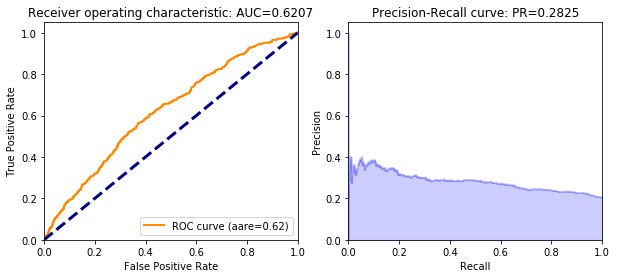

In [25]:
ROC_AUC(glm_v1,test_hex,'loan_default')

In [26]:
#outputing the coefficients table
coefs = glm_v1._model_json['output']['coefficients_table'].as_data_frame()
coefs = pd.DataFrame(coefs)
coefs.sort_values(by='standardized_coefficients',ascending=False)

,names,coefficients,standardized_coefficients
66,TD013,0.021610,0.108478
62,TD005,0.021710,0.059154
64,TD009,0.006760,0.026471
84,PA031,0.000253,0.025089
81,PA028,0.000074,0.007802
53,TD051.nan,0.000000,0.000000
59,AP009,0.000000,0.000000
58,AP008,0.000000,0.000000
57,AP007,0.000000,0.000000
55,AP002,0.000000,0.000000


In [37]:
glm_v2 = H2OGeneralizedLinearEstimator(family= "binomial", lambda_ = 0.05, 
                                       fold_assignment="auto")
glm_v2.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [40]:
glm_v2.predict(test_hex)

glm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
1,0.807355,0.192645
0,0.821939,0.178061
0,0.81672,0.18328
0,0.815278,0.184722
1,0.795569,0.204431
0,0.845525,0.154475
0,0.847223,0.152777
1,0.733002,0.266998
0,0.841128,0.158872
1,0.774681,0.225319


In [41]:
predictions = glm_v2.predict(test_hex)['p1']
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

glm prediction progress: |████████████████████████████████████████████████| 100%


,loan_default,p1
0,0,0.192645
1,0,0.178061
2,0,0.183280
3,0,0.184722
4,0,0.204431


In [42]:
createGains(glm_v2)

glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,64,176,240,64,176,0.13,0.09,49.0,1.31,4.0,26.67
1,240,66,174,480,130,350,0.27,0.18,98.0,1.33,9.0,27.08
2,240,72,168,720,202,518,0.41,0.27,147.0,1.37,14.0,28.06
3,240,60,180,960,262,698,0.53,0.37,196.0,1.34,16.0,27.29
4,240,53,187,1200,315,885,0.64,0.46,245.0,1.29,18.0,26.25
5,240,31,209,1440,346,1094,0.71,0.57,294.0,1.18,14.0,24.03
6,240,36,204,1680,382,1298,0.78,0.68,343.0,1.11,10.0,22.74
7,240,33,207,1920,415,1505,0.85,0.79,392.0,1.06,6.0,21.61
8,240,37,203,2160,452,1708,0.92,0.89,441.0,1.02,3.0,20.93


glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\rdiml\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: [HTC, IPHONE3, IVVI, KINGSUN, SONY, ZUK]
  warnings.warn(w)



   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



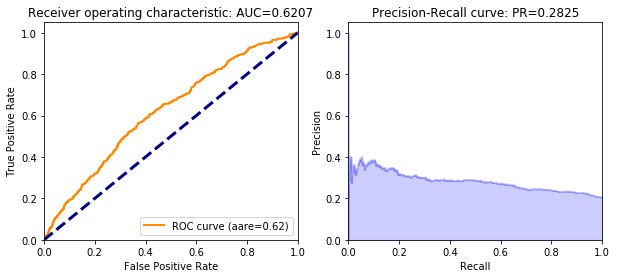

In [43]:
ROC_AUC(glm_v2,test_hex,'loan_default')

## AutoML

In [17]:
from h2o.automl import H2OAutoML

In [28]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [29]:
aml_v1 = H2OAutoML(max_runtime_secs = 60, max_models=20, seed=1)
aml_v1.train(predictors,target,training_frame=train_hex)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [30]:
aml_v1.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GLM_grid_1_AutoML_20191124_205256_model_1,0.145507,0.381454,0.145507,0.291383,0.267651
StackedEnsemble_BestOfFamily_AutoML_20191124_205256,0.145597,0.381572,0.145597,0.291007,0.267781
StackedEnsemble_AllModels_AutoML_20191124_205256,0.145674,0.381673,0.145674,0.291086,0.267867
GBM_5_AutoML_20191124_205256,0.147487,0.38404,0.147487,0.291095,0.270156
DeepLearning_1_AutoML_20191124_205256,0.148001,0.384709,0.148001,0.296434,0.271395
GBM_grid_1_AutoML_20191124_205256_model_1,0.150078,0.387399,0.150078,0.301973,0.271402
GBM_1_AutoML_20191124_205256,0.150084,0.387407,0.150084,0.2924,0.272996
GBM_grid_1_AutoML_20191124_205256_model_5,0.150351,0.387751,0.150351,0.30239,0.271684
GBM_grid_1_AutoML_20191124_205256_model_3,0.150908,0.388469,0.150908,0.303144,0.272279
GBM_2_AutoML_20191124_205256,0.151381,0.389076,0.151381,0.292397,0.274261


In [31]:
pred = aml_v1.predict(test_hex)#['p1']
pred.head()

glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\rdiml\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: [HTC, IPHONE3, IVVI, KINGSUN, SONY, ZUK]
  warnings.warn(w)


predict
0.219213
0.138501
0.187012
0.213732
0.322146
0.0898063
0.101116
0.43495
0.114449
0.225387


In [32]:
perf = aml_v1.leader.model_performance(test_hex)
perf


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 0.15612842373168298
RMSE: 0.3951308944282679
MAE: 0.3033918869777142
RMSLE: 0.2759170089777021
R^2: 0.03910704060851167
Mean Residual Deviance: 0.15612842373168298
Null degrees of freedom: 2399
Residual degrees of freedom: 2314
Null deviance: 390.625
Residual deviance: 374.70821695603917
AIC: 2527.921644141158


In [34]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(aml_v1)

glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,77,163,240,77,163,0.16,0.09,49.0,1.57,7.0,32.08
1,240,86,154,480,163,317,0.33,0.17,98.0,1.66,16.0,33.96
2,240,55,185,720,218,502,0.44,0.26,147.0,1.48,18.0,30.28
3,240,61,179,960,279,681,0.57,0.36,196.0,1.42,21.0,29.06
4,240,47,193,1200,326,874,0.67,0.46,245.0,1.33,21.0,27.17
5,240,43,197,1440,369,1071,0.75,0.56,294.0,1.26,19.0,25.62
6,240,43,197,1680,412,1268,0.84,0.66,343.0,1.20,18.0,24.52
7,240,33,207,1920,445,1475,0.91,0.77,392.0,1.14,14.0,23.18
8,240,33,207,2160,478,1682,0.98,0.88,441.0,1.08,10.0,22.13


In [18]:
aml_v2 = H2OAutoML(max_runtime_secs = 60, max_models=20, seed=100, nfolds=3)
aml_v2.train(predictors,target,training_frame=train_hex)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [19]:
aml_v2.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GLM_grid_1_AutoML_20191124_215217_model_1,0.14487,0.380618,0.14487,0.290454,0.267046
StackedEnsemble_BestOfFamily_AutoML_20191124_215217,0.144921,0.380685,0.144921,0.289749,0.267188
StackedEnsemble_AllModels_AutoML_20191124_215217,0.14502,0.380816,0.14502,0.289487,0.267329
GBM_5_AutoML_20191124_215217,0.146872,0.383238,0.146872,0.290878,0.269507
DeepLearning_grid_1_AutoML_20191124_215217_model_1,0.147782,0.384424,0.147782,0.289384,0.270955
GBM_1_AutoML_20191124_215217,0.148449,0.38529,0.148449,0.289988,0.27143
DeepLearning_grid_1_AutoML_20191124_215217_model_3,0.148677,0.385587,0.148677,0.279572,0.268122
GBM_3_AutoML_20191124_215217,0.149263,0.386346,0.149263,0.289182,0.272603
GBM_2_AutoML_20191124_215217,0.149512,0.386668,0.149512,0.289298,0.272448
DeepLearning_1_AutoML_20191124_215217,0.149516,0.386672,0.149516,0.283033,0.271211


In [20]:
pred = aml_v2.predict(test_hex)
pred.head()

glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\rdiml\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: [HTC, IPHONE3, IVVI, KINGSUN, SONY, ZUK]
  warnings.warn(w)


predict
0.21883
0.138263
0.18553
0.213196
0.324532
0.0845795
0.099018
0.45597
0.112507
0.22245


In [22]:
perf = aml_v2.leader.model_performance(test_hex)
perf


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 0.15624153285922684
RMSE: 0.3952739971959031
MAE: 0.30318995735718
RMSLE: 0.2761364554271633
R^2: 0.038410910066089765
Mean Residual Deviance: 0.15624153285922684
Null degrees of freedom: 2399
Residual degrees of freedom: 2314
Null deviance: 390.625
Residual deviance: 374.9796788621444
AIC: 2529.6597236986945


In [24]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(aml_v2)

glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,81,159,240,81,159,0.17,0.08,49.0,1.65,9.0,33.75
1,240,77,163,480,158,322,0.32,0.17,98.0,1.61,15.0,32.92
2,240,58,182,720,216,504,0.44,0.26,147.0,1.47,18.0,30.00
3,240,65,175,960,281,679,0.57,0.36,196.0,1.43,21.0,29.27
4,240,45,195,1200,326,874,0.67,0.46,245.0,1.33,21.0,27.17
5,240,43,197,1440,369,1071,0.75,0.56,294.0,1.26,19.0,25.62
6,240,42,198,1680,411,1269,0.84,0.66,343.0,1.20,18.0,24.46
7,240,35,205,1920,446,1474,0.91,0.77,392.0,1.14,14.0,23.23
8,240,32,208,2160,478,1682,0.98,0.88,441.0,1.08,10.0,22.13


In [27]:
#I couldn't get the ROC curve to be produced
ROC_AUC(aml_v2,test_hex,'loan_default')

glm prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\rdiml\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: [HTC, IPHONE3, IVVI, KINGSUN, SONY, ZUK]
  warnings.warn(w)


H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Column p1 not found
  Request: POST /99/Rapids
    data: {'ast': "(tmp= py_8_sid_8267 (cols_py transformation_8ea4_GLM_grid_1_AutoML_20191124_215217_model_1_on_Key_Frame__upload_82d4ce2c4c6ff19d57b5795c87c1404b.hex 'p1'))", 'session_id': '_sid_8267'}
